# Clipping raster to a shapefile
When there is a satellite image, rarely a scientist or data analyst is interested in the entire satellite image. Clipping satellite image is important to better visualize the area of interest. Shapefiles (vector data) can be used as a boundary defining the area of interest and mask (discard) the unnecessary data. The following satellite image contains landsat image which is clipped to a Grand Lake O' The Cherokees shapefile. 

In [1]:
#Import the required libraries to open and work with both raster and shapefiles
from osgeo import gdal, gdal_array, ogr, osr
import shapefile
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
import os

# Steps to clip raster to a shapefile
1. Load the image into an array
2. Read shapefile using pyshp
3. Convert shapefile into a georeferenced image 
4. Grab the required part of the georeferenced image based on the bounding box of the shapefile
5. Filter the selected image using mask created by PIL library
6. Save the output clipped raster as 'Grandlake.tif'

In [4]:
# Give path to all the input and output files required in the clipping process
raster = "LC08_L1TP_026035_20160917_20170222_01_T1_B5.TIF"
# vector shapefile used in the clipping process
shp = "OWRB_32615_smooth"
# Give the name of the ouptput clipped ras|ter file
output = "Grandlake"
# Need to figure a way to download files from dropbox using python
if not os.path.isfile(raster):
    print('Download the raster file based on the link either provided in the readme.md file')

In [5]:
# get the source reference
driver = ogr.GetDriverByName('ESRI Shapefile')
dataset = driver.Open(shp + '.shp')
layer = dataset.GetLayer()
inSpatialRef = layer.GetSpatialRef()
dataset = None

# get the destination reference
outSpatialRef = osr.SpatialReference()
dataset = gdal.Open(raster)
prj = dataset.GetProjection()
outSpatialRef = osr.SpatialReference(wkt=prj)

# create the transform
coordTrans = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)

(7921, 7791)


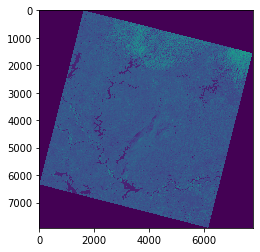

In [10]:
# First read the raster as an array using gdal and plot the array using matplotlib
srcArray = gdal_array.LoadFile(raster)
plt.imshow(srcArray)
print(srcArray.shape)

In [6]:
# To get the world info geotransform is used in gdal
srcImage = gdal.Open(raster)
geoTrans = srcImage.GetGeoTransform()

In [7]:
geoTrans

(228885.0, 30.0, 0.0, 4108515.0, 0.0, -30.0)

In [8]:
# Use pyshp to read the shapefile
sf = shapefile.Reader("{}.shp".format(shp))
print(len(sf.shapes()))

1


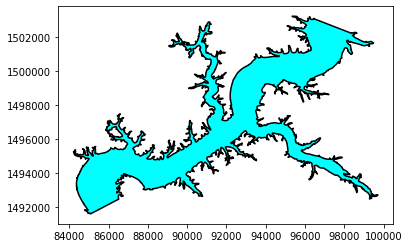

In [8]:
# Plotting the shapefile to check how the shapfile of the grandlake looks like
%matplotlib inline
#Plotting a single shape over the map
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y, 'k')
    plt.fill(x,y, fc = 'aqua')

# Pixel location of geospatitial coordinate
The following function calculates the pixel location of the geospatital coordinate based on the GetGeoTransform function. The GeoTransform function consists of coordinates in the upper left corner of the image, pixel spacing and an additional rotation. By knowing these values, location of each pixel can be easily identified such that 

1. "228885" represents the upper left east coordinate (Horizontal)
2. "30" is the E-W pixel spacing
3. There is no rotation of the image (0 represents the image is pointing "North")
4. "4108515" represens the north coordinate of the image (Vertical)
5. There is no rotation of the image (0 degrees)
6. "-30" The N-S pixel spacing, negative as we will be counting from upper left corner

In [9]:
def world2Pixel(geoMatrix, x, y):
    """
    Uses a gdal geomatrix (gdal.GetGeoTransform()) to calculate
    the pixel location of a geospatial coordinate
    """
    ulX = geoMatrix[0]
    ulY = geoMatrix[3]
    xDist = geoMatrix[1]
    yDist = geoMatrix[5]
    rtnX = geoMatrix[2]
    rtnY = geoMatrix[4]
    pixel = int((x - ulX) / xDist)
    line = int((ulY - y) / abs(yDist))
    return (pixel, line)

In [10]:
# convert the vector layer extent into image pixel coordintes
minX, minY, maxX, maxY = sf.bbox
print(minX, minY, maxX, maxY)

84214.51999999955 1491598.7589999996 99707.77199999988 1503202.171


In [11]:
ulX, ulY = world2Pixel(geoTrans, minX, maxY)
lrX, lrY = world2Pixel(geoTrans, maxX, minY)
print(ulX, lrX)
print(ulY, lrY)
# There is something wrong with with the ulY and lrY values because there are going outside the srcArray shape?

-4822 -4305
86843 87230


517 387


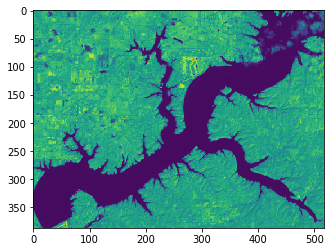

In [12]:
#Calculate the pixel size of the new image
pxWidth = int(lrX - ulX)
pxHeight = int(lrY - ulY)
print(pxWidth, pxHeight)
# Taking only the part of the image based on the extents of the shapefile
clip = srcArray[1963:2350, ulX-50:lrX-50]
plt.imshow(clip)

In [13]:
#Create a new geomatrix for the clipped image 
geoTrans = list(geoTrans)
geoTrans[0] = minX
geoTrans[3] = maxY

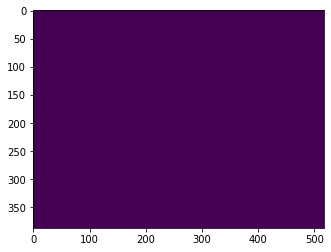

In [14]:
#Creating an 8 bit, black and white mask to mask the image and map points to pixels to draw the boundary of the grand lake
pixels = []
for pixel in sf.shape(0).points:
    pixels.append(world2Pixel(geoTrans, pixel[0], pixel[1]))
rasterPoly = Image.new("L", (pxWidth, pxHeight), 1)
plt.imshow(rasterPoly) 

In [15]:
# Create a blank image in PIL to draw the grandlake polygon
rasterize = ImageDraw.Draw(rasterPoly)
rasterize.polygon(pixels, 0)

(200079,)
(387, 517)


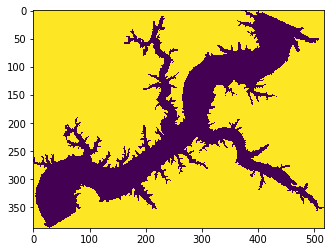

In [18]:
# Now the black and white image can be converted to an array using the following function
def imageToArray(rasterPoly):
    """
    Converts a Python Imaging Library array to a gdal_array image.
    """
    mask = gdal_array.numpy.frombuffer(rasterPoly.tobytes(), 'b')
    print(mask.shape)
    mask.shape = rasterPoly.im.size[1], rasterPoly.im.size[0]
    print(mask.shape)
    return mask
mask = imageToArray(rasterPoly)
plt.imshow(mask)

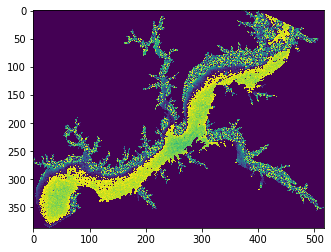

In [19]:

# Clip the image using the mask
clip = gdal_array.numpy.choose(mask, (clip, 0)).astype(
                                gdal_array.numpy.uint8)
plt.imshow(clip)